In [1]:
import os
import glob
import json
import collections
import numpy as np
import pandas as pd
import matplotlib

'''
 Please modify the split names and main_folder for the dataset if necessary. 
 I assume the structure of data folder to be
 
 main_folder/split_names/task_name/trial_name/traj_data.json
'''

split_names = ["train", "valid_seen", "valid_unseen"]
main_folder = "json_2.1.0"

In [2]:
'''
read_file and load json
'''
def get_filepath_dict(output_as_txt=False): # indicate whether to output the paths as txt files
    '''
    generate a dict that maps split names to a list that contains all related json files
    return {split_name:[list_of_filepaths]}
    '''
    filename_dict = {}
    for split_name in split_names:
        folder_path = os.path.join(main_folder, split_name)
        if os.path.isdir(folder_path):
            file_paths = list(glob.glob(folder_path + '/*/*/*.json'))
            file_paths.sort()
        filename_dict[split_name] = file_paths
        if output_as_txt:
            with open(split_name+"_filepaths.txt", "w") as f:
                for file_path in file_paths:
                    f.write(file_path + "\n")
    return filename_dict # return dict with keys to be split names and values to be lists of filepaths

def read_filepath_from_txt(txt_path): # read file paths from a txt
    '''
    read filepaths as a list
    return [list_of_filepaths]
    '''
    filename_list = []
    with open(txt_path, "r") as f:
        filename_list = list(f.readlines())
    filename_list = [line.strip() for line in filename_list]
    return filename_list # return a list of filenames

def load_json(file_path): # load one json
    with open(file_path, "r") as f:
        traj_dict = json.load(f)
    return traj_dict # return the dict

def load_json_all(file_path_list): # load all json given a list of file paths
    info_all = []
    for file_path in file_path_list:
        traj_dict = load_json(file_path)
        info_all.append(traj_dict)
    return info_all # a list of dict read by json

In [3]:

'''
get basic information from the dict
'''

def get_low_level_actions(traj_dict, non_repeat=True):
    '''
    load an low_level action sequence from the dict given by json file
    return [list_of_actions], [whether_object_involved], [repeat numbers]
    
    by setting remove repeat to true, 
    we consider the single action performed continuously to be a one action, e.g.
    w/o remove repeat: [a0, a1, a1, a2, a3, a3, a3, a4]
    w/ remove repeat: [a0, a1, a2, a3, a4]
    
    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    action_sequence_raw = [action_dict['api_action']['action'] for action_dict in action_dict_sequence]
    object_involved_raw = [action_dict['discrete_action']['args']!={} for action_dict in action_dict_sequence]
    if not non_repeat:
        return action_sequence_raw, object_involved_raw, [1] * len(action_dict_sequence)
    
    action_squence_nonrepeat = []
    object_involved_nonrepeat = []
    action_repeat_number = []
    current_action = ""
    for action, object_involved in zip(action_sequence_raw, object_involved_raw):
        if action != current_action:
            action_squence_nonrepeat.append(action)
            object_involved_nonrepeat.append(object_involved)
            current_action = action
            action_repeat_number.append(1)
        else:
            action_repeat_number[-1] += 1
    return action_squence_nonrepeat, object_involved_nonrepeat, action_repeat_number

def get_high_level_actions(traj_dict):
    '''
    load an low_level action sequence from the dict given by json file
    return [a1, a2, a3, a4]
    
    '''
    action_dict_sequence = traj_dict['plan']['high_pddl']
    action_sequence = [action_dict['discrete_action']['action'] for action_dict in action_dict_sequence]
    return action_sequence

def get_all_objects(traj_dict, non_repeat=False):
    '''
    load the list of objects in the scene (not necessarily acted on)
    return [list_of_object_names]
    '''
    object_dict_list = traj_dict['scene']['object_poses']
    object_list_raw = [object_dict['objectName'].split("_")[0] for object_dict in object_dict_list]
    if not non_repeat:
        return object_list_raw
    object_list_nonrepeat = list(set(object_list_raw))
    return object_list_nonrepeat

def get_instructions(traj_dict):
    '''
    load the instructions
    return [list_of_instruction_sequences(list)], [list_of_task_description]
    '''
    ins_dict_list = traj_dict["turk_annotations"]['anns']
    high_descs = [ins_dict['high_descs'] for ins_dict in ins_dict_list]
    task_descs = [ins_dict['task_desc'] for ins_dict in ins_dict_list]
    return high_descs, task_descs

def get_task_type(traj_dict):
    return traj_dict['task_type']

def get_object_acted_on(traj_dict):
    '''
    convert a dict read from json to object acted on
    return [list_of_objects]

    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    object_list = [action_dict['api_action']['objectId'].split("|")[0] for action_dict in action_dict_sequence if action_dict['discrete_action']['args']!={}]
    return object_list

def get_object_and_bbox(traj_dict):
    '''
    convert a dict read from json to object acted on and corresponding bounding boxes
    return [(o1, bb1), (o2, bb2)]
    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    object_bb_list = [ (action_dict['api_action']['objectId'].split("|")[0],
                        action_dict['discrete_action']['args']['bbox']) 
                      for action_dict in action_dict_sequence if action_dict['discrete_action']['args']!={}]
    return object_bb_list

In [4]:
'''
get length, action/instruction
'''

def get_instruction_length(traj_dict):
    '''
    get the average number of instructions for each trial
    return float(average_number_of_length)
    '''
    ins_lists = get_instructions(traj_dict)[0]
    return sum([len(ins_list) for ins_list in ins_lists])/len(ins_lists)

def get_action_seq_length(traj_dict, low_level=True, unique = True):
    '''
    get the length of action for each trial
    return float(length_of_action_sqeuence)
    '''
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    return len(action_lists)
    
def get_instruction_to_action_ratio(traj_dict, low_level=True, unique=True):
    return get_instruction_length(traj_dict)/get_action_seq_length(traj_dict,low_level, unique = True)

In [5]:
'''
construct pairs, which might be used in calculating relationship
'''

def get_action_object_pairs(traj_dict):
    '''
    convert a dict read from json to a series of action-object pairs (an action and the object acted on)
    return [(a1, o1), (a1, o2)]
    '''
    action_dict_sequence = traj_dict['plan']['low_actions']
    action_object_pairs = [ (action_dict['api_action']['action'], action_dict['api_action']['objectId'].split("|")[0]) 
                           for action_dict in action_dict_sequence if action_dict['discrete_action']['args']!={}]
    return action_object_pairs

def get_action_action_pairs(traj_dict, low_level=True, unique=True):
    '''
    convert a dict read from json to a series of action-acton pairs (an action and the following action)
    return [(a1, a2), (a1, a3), (a2, a3)]
    '''
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    action_action_pairs = [(action_lists[i], action_lists[i+1]) for i in range(len(action_lists)) if i < (len(action_lists)-1)]
    return action_action_pairs

def get_task_action_pairs(traj_dict, low_level=True, unique=True):
    '''
    convert a dict read from json to task-acton pairs
    return [(t1, a2), (t1, a3), (t2, a1)]
    '''
    task_type = get_task_type(traj_dict)
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    return [(task_type, action) for action in action_lists]

def get_attempts_action_pairs(traj_dict, low_level=True, unique=True):
    '''
    convert a dict read from json to attempt-acton pairs
    return [(t1, a2), (t1, a3), (t2, a1)]
    '''
    trial_id = traj_dict['task_id']
    if low_level:
        action_lists = get_low_level_actions(traj_dict, unique)[0]
    else:
        action_lists = get_high_level_actions(traj_dict)
    return [(trial_id, action) for action in action_lists]

In [20]:
'''
calculate statistical information
'''

def get_pair_frequency(pair_list, normalize = True):
    '''
    convert a list of term paris to a 2-d matrix
    input: [(t1, t2), (t1, t3), (t2, t3)]
    output: matrix, key list, value list
           t2, t3
        t1 0.5 0.5
        t2 0   0.5
        [t1, t2]
        [t2, t3]
    '''

    all_keys = list(set(list([pair[0] for pair in pair_list])))
    all_values = list(set(list([pair[1] for pair in pair_list])))
    all_keys.sort()
    all_values.sort()
    freq_matrix = np.zeros([len(all_keys), len(all_values)])
    count_dict = collections.Counter(pair_list)
    def fill_matrix(indexs):
        i_key, i_value = indexs
        pair = (all_keys[i_key], all_values[i_value])
        freq_matrix[i_key][i_value] = count_dict.get(pair, 0)
    list(map(lambda x:fill_matrix(x), [(i_key, i_value) for i_key in range(len(all_keys)) for i_value in range(len(all_values))]))
    if normalize:
        freq_matrix = freq_matrix/(np.sum(freq_matrix, axis=1, keepdims=True)+1e-7)
    return freq_matrix, all_keys, all_values

def get_frequency(name_list, normalize=True):
    '''
    convert a list of terms to a vector representing the frequency
    input: (t1, t2, t3, t1)
    output: (0.5, 0.25, 0.25), [t1, t2, t3]
    '''
    count_dict = collections.Counter(name_list)
    keys = list(count_dict.keys())
    keys.sort()
    frequency_vector = np.array([count_dict[key] for key in keys])
    if normalize:
        frequency_vector = frequency_vector/(np.sum(frequency_vector, keepdims=True)+1e-7)
    return frequency_vector, keys

In [7]:
filepaths_dict = get_filepath_dict()
train_paths = filepaths_dict['train']
val_seen_paths = filepaths_dict['valid_seen']
val_unseen_paths = filepaths_dict['valid_unseen']

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

def get_instructions_verbs(text):
    verbs = []
    # if type(text) == str:
    #     text = nlp(text)
    for tok in text:
        if tok.pos_ == "VERB":
            verbs.append(tok.lemma_)
    return verbs

def get_instructions_nouns(text):
    nouns = []
    # if type(text) == str:
    #     text = nlp(text)
    for tok in text:
        if tok.pos_ == "NOUN":
            nouns.append(tok.lemma_)
    return nouns

In [13]:
train_traj_list = load_json_all(train_paths)
val_seen_traj_list = load_json_all(val_seen_paths)
val_unseen_traj_list = load_json_all(val_unseen_paths)

In [58]:
train_instructions = {'detail':[get_instructions(elt)[0] for elt in train_traj_list], 'task':[get_instructions(elt)[1] for elt in train_traj_list]}
val_seen_instructions = {'detail':[get_instructions(elt)[0] for elt in val_seen_traj_list], 'task':[get_instructions(elt)[1] for elt in val_seen_traj_list]}
val_unseen_instructins = {'detail':[get_instructions(elt)[0] for elt in val_unseen_traj_list], 'task':[get_instructions(elt)[1] for elt in val_unseen_traj_list]}
 

In [61]:
def apply_spacy(e):
    if type(e) == list:
        return nlp(' '.join(e))
    else:
        return nlp(e)

from tqdm import tqdm 
def unpack_sets(d):
    new_d = dict()
    for k in d:
        new_d[k] = d[k]
        l = []
        v = []
        n = []
        for sets in tqdm(d[k]):
            for set in sets:
                doc = apply_spacy(set)
                l.append(doc)
                v.append(get_instructions_verbs(doc))
                n.append(get_instructions_nouns(doc))
        new_d[k+'_unpack'] = l
        new_d[k+'_verbs'] = v
        new_d[k+'_nouns'] = n
    return new_d
train_instructions = unpack_sets(train_instructions)
val_seen_instructions = unpack_sets(val_seen_instructions)
val_unseen_instructins = unpack_sets(val_unseen_instructins)

100%|██████████| 255/255 [00:05<00:00, 50.36it/s]


In [79]:
val_unseen_instructions = val_unseen_instructins

In [69]:
def get_statistics(l):
    return {'mean':np.average(l), 'std':np.std(l), 'min':np.min(l), 'max':np.max(l)}
    
def get_split_statistics(train, val1, val2, column):
    train_stats = get_statistics([len(elt) for elt in train[column]])
    val_seen_stats = get_statistics([len(elt) for elt in val1[column]])
    val_unseen_stats = get_statistics([len(elt) for elt in val2[column]])
    print(pd.DataFrame([{
            'split':'train',
            **train_stats
        }, {
            'split':'val seen',
            **val_seen_stats
        }, {
            'split':'val unseen',
            **val_unseen_stats
        }]).to_latex(index=False, float_format="{:0.2f}".format))


In [73]:
get_split_statistics(train_instructions, val_seen_instructions, val_seen_instructions, 'detail_verbs')

\begin{tabular}{lrrrr}
\toprule
     split &  mean &  std &  min &  max \\
\midrule
     train & 13.13 & 6.81 &    1 &   68 \\
  val seen & 12.98 & 7.31 &    2 &   53 \\
val unseen & 12.98 & 7.31 &    2 &   53 \\
\bottomrule
\end{tabular}



In [81]:
data_split = val_seen_instructions
data_split = val_unseen_instructions
data_split = train_instructions

for i in range(len(data_split['task_nouns'])):
    elt = data_split['task_nouns'][i]
    if len(elt) == 0:
        print(data_split['task_unpack'][i])
        print(data_split['task_verbs'][i])

Put the CD into the white safe
['put']
Put the CD into the white safe
['put']
The ro
[]
The ro
[]


In [87]:
def flatten(l):
    new_l = []
    for elt in l:
        new_l += elt
    return new_l

def apply_flatten(d):
    d['task_nouns_flatten'] = flatten(d['task_nouns'])
    d['detail_nouns_flatten'] = flatten(d['detail_nouns'])
    d['task_verbs_flatten'] = flatten(d['task_verbs'])
    d['detail_verbs_flatten'] = flatten(d['detail_verbs'])
    
apply_flatten(train_instructions)
apply_flatten(val_seen_instructions)
apply_flatten(val_unseen_instructions)

<AxesSubplot:>

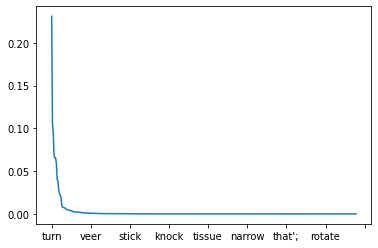

In [112]:
data_split = train_instructions
pd.Series(train_instructions['detail_verbs_flatten']).value_counts(normalize=True).plot(kind='line')
# pd.Series(train_instructions['detail_nouns_flatten']).value_counts(normalize=True).plot(kind='line')


In [118]:
train_verbs = set(train_instructions['detail_verbs_flatten']) 
print(sum([verb not in train_verbs for verb in val_seen_instructions['detail_verbs_flatten'] + val_unseen_instructions['detail_verbs_flatten']])/len(val_seen_instructions['detail_verbs_flatten'] + val_unseen_instructions['detail_verbs_flatten']))

0.00028376844494892167


In [119]:
train_verbs = set(train_instructions['detail_nouns_flatten']) 
print(sum([verb not in train_verbs for verb in val_seen_instructions['detail_nouns_flatten'] + val_unseen_instructions['detail_nouns_flatten']])/len(val_seen_instructions['detail_nouns_flatten'] + val_unseen_instructions['detail_nouns_flatten']))

0.0006951466127401415


In [11]:
def get_action_pairs(l):
    pairs = []
    if len(l) > 1:
        pairs = list(zip(l[:-1], l[1:]))
    return pairs

all_pairs = []
for s in train_verbs:
    all_pairs += get_action_pairs(s)
    

In [22]:
all_keys = set(list([pair[0] for pair in all_pairs]))

TypeError: 'list' object is not callable

In [10]:
import json

with open('data_analysis.json') as outfile:
   train_verbs = json.loads(outfile.read())

In [21]:
conf_matrix = get_pair_frequency(all_pairs, normalize = False)

TypeError: 'list' object is not callable

In [134]:
import seaborn as sn
setup_dp = pd.DataFrame(conf_matrix[0].astype(int), index = conf_matrix[1],
                  columns = conf_matrix[2])
plt.figure(figsize = (10,8))
sn.heatmap(setup_dp,annot=True,fmt="d", center =50000, cmap = "Greens") 

IndexError: list index out of range

In [50]:
# Sentences.
train_stats = get_statistics([len(get_instructions_verbs(' '.join(elt))) for elt in train_instructions['detail_unpack']])
val_seen_stats = get_statistics([len(get_instructions_verbs(' '.join(elt))) for elt in val_seen_instructions['detail_unpack']])
val_unseen_stats = get_statistics([len(get_instructions_verbs(' '.join(elt))) for elt in val_unseen_instructins['detail_unpack']])
print(pd.DataFrame([{'split':'train',**train_stats}, {'split':'val seen',**val_seen_stats}, {'split':'val unseen',**val_unseen_stats}]).to_latex(index=False, float_format="{:0.2f}".format))

\begin{tabular}{lrrrr}
\toprule
     split &  mean &  std &  min &  max \\
\midrule
     train & 13.13 & 6.81 &    1 &   68 \\
  val seen & 12.98 & 7.31 &    2 &   53 \\
val unseen & 12.79 & 6.82 &    2 &   44 \\
\bottomrule
\end{tabular}



In [26]:
train_stats = get_statistics([len(elt) for elt in train_instructions['detail']])
val_seen_stats = get_statistics([len(elt) for elt in val_seen_instructions['detail']])
val_unseen_stats = get_statistics([len(elt) for elt in val_unseen_instructins['detail']])
print(pd.DataFrame([{'split':'train',**train_stats}, {'split':'val_seen',**val_seen_stats}, {'split':'val_unseen',**val_unseen_stats}]).to_latex(index=False, float_format="{:0.2f}".format))

\begin{tabular}{lrrrr}
\toprule
{} &      mean &       std &  min &  max \\
\midrule
0 &  3.198205 &  0.680997 &    3 &    6 \\
\bottomrule
\end{tabular}



In [47]:
train_stats = get_statistics([len(elt) for elt in train_instructions['detail_unpack']])
val_seen_stats = get_statistics([len(elt) for elt in val_seen_instructions['detail_unpack']])
val_unseen_stats = get_statistics([len(elt) for elt in val_unseen_instructins['detail_unpack']])
print(pd.DataFrame([{'split':'train',**train_stats}, {'split':'val_seen',**val_seen_stats}, {'split':'val_unseen',**val_unseen_stats}]).to_latex(index=False, float_format="{:0.2f}".format))

\begin{tabular}{lrrrr}
\toprule
     split &  mean &  std &  min &  max \\
\midrule
     train &  6.72 & 2.49 &    3 &   19 \\
  val\_seen &  6.79 & 2.73 &    4 &   16 \\
val\_unseen &  6.26 & 2.33 &    4 &   14 \\
\bottomrule
\end{tabular}



In [ ]:
high_descs, task_desc = get_instructions(val_seen_traj_list[0])


In [11]:
high_descs[0], task_desc[0]

(['go to the table with the safe ',
  'pick up the clock',
  'take the clock to the desk',
  'turn on the lamp'],
 'look at the clock under the lamp')

In [12]:
get_instructions_verbs(task_desc[0])

['look']

In [36]:
train_instructions['task'][0]

['Pick up the alarm clock and turn on the lamp.',
 'Carry an alarm clock while turning on a lamp',
 'examine an alarm clock by the light of the lamp on the dresser']

In [37]:
train_instructions['detail'][0]

[['Turn left and face the dresser.',
  'Pick up the alarm clock from the dresser.',
  'Turn left, look and then face the lamp.',
  'Turn the lamp on.'],
 ['Move to the white dresser to the left of the bed',
  'Pick up the alarm clock on top of the dresser',
  'Carry the alarm clock to the left side of the dresser',
  'Turn on the lamp on top of the dresser'],
 ['turn to the left to face the dresser',
  'pick up the alarm clock off of the dresser',
  'move to the left to face the left side of the dresser where the lamp is sitting',
  'turn the lamp on']]